## 1. Import all the necessary libraries and packages

In [1]:
import os
import os.path
from pathlib import Path
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import plotly
import k3d

print('Successfully imported all libraries')

Successfully imported all libraries


## 2. Select two "views" to be considered for the reconstruction:

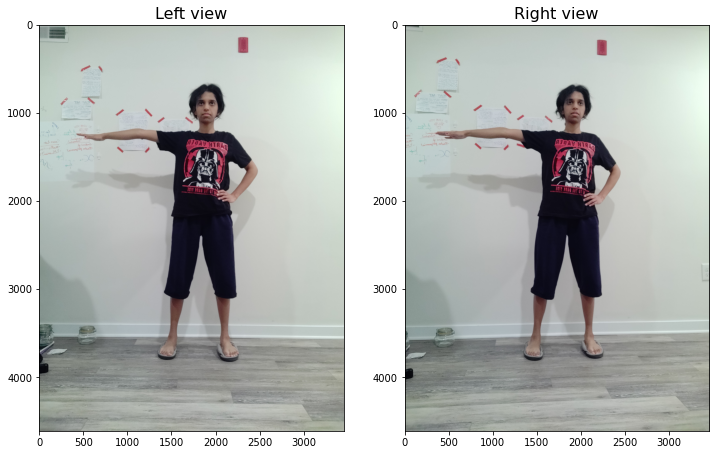

In [2]:
path_i = os.path.normpath('data/left_me.jpg')
path_j = os.path.normpath('data/right_me.jpg')

view_i = cv.imread(path_i)
view_j = cv.imread(path_j)

f, axs = plt.subplots(1, 2, figsize=(12, 9))

axs[0] = plt.subplot(1, 2, 1)
axs[0].set_title('Left view', fontsize=16)
dummy = axs[0].imshow(view_i[:,:,::-1])

axs[1] = plt.subplot(1, 2, 2)
axs[1].set_title('Right view', fontsize=16)
dummy = axs[1].imshow(view_j[:,:,::-1])

## 3. Erase the background features using pretrained ResNet based Segmentation

[0. 1.]


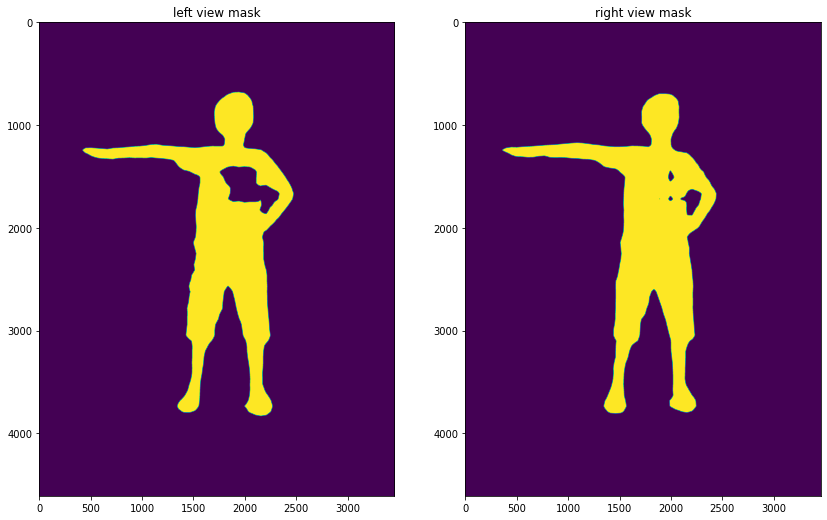

In [6]:
from erase_background import erase_bg

mask_i = cv.rotate(erase_bg(path_i), cv.ROTATE_90_COUNTERCLOCKWISE)
mask_j = cv.rotate(erase_bg(path_j), cv.ROTATE_90_COUNTERCLOCKWISE)

print(np.unique(mask_i))

f, ax = plt.subplots(1, 2, figsize=(14, 16))

ax[0] = plt.subplot(1, 2, 1)
ax[0].set_title('left view mask')
ax[0].imshow(mask_i)

ax[1] = plt.subplot(1, 2, 2)
ax[1].set_title('right view mask')
ax[1].imshow(mask_j)

### NOTE: Inaccurate Segmentation masks generated by ResNet50

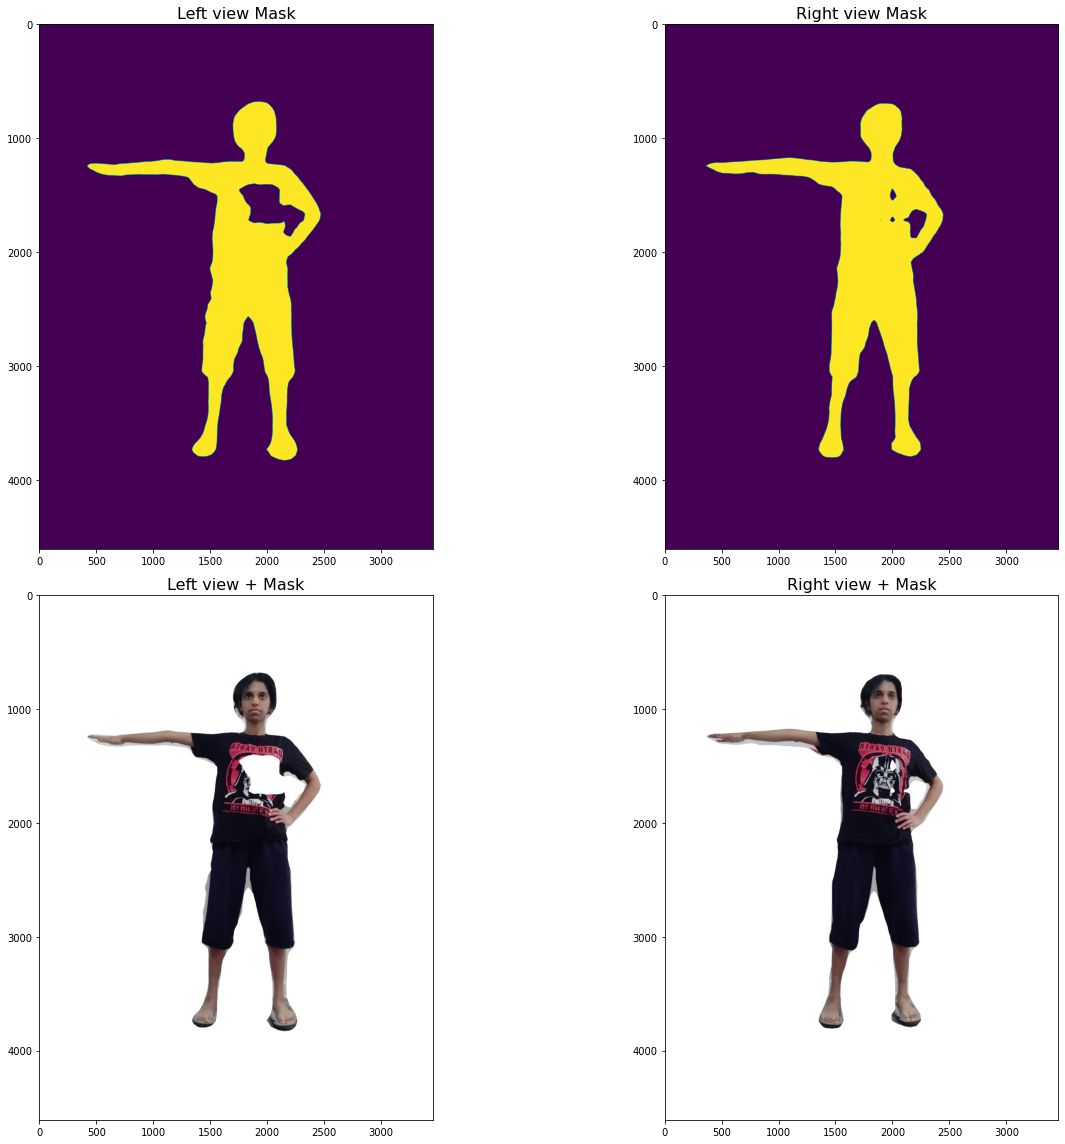

In [7]:
f, axs = plt.subplots(2, 2, figsize=(20, 16))

axs[0,0] = plt.subplot(2, 2, 1)
axs[0,0].set_title('Left view Mask', fontsize=16)
dummy = axs[0,0].imshow(mask_i)

axs[0,1] = plt.subplot(2, 2, 2)
axs[0,1].set_title('Right view Mask', fontsize=16)
dummy = axs[0,1].imshow(mask_j)


im_i = np.zeros_like(view_i)
im_j = np.zeros_like(view_j)

im_i[:,:,0] = view_i[:,:,0] * mask_i + (1-mask_i)*255
im_i[:,:,1] = view_i[:,:,1] * mask_i + (1-mask_i)*255 
im_i[:,:,2] = view_i[:,:,2] * mask_i + (1-mask_i)*255

im_j[:,:,0] = view_j[:,:,0] * mask_j + (1-mask_j)*255
im_j[:,:,1] = view_j[:,:,1] * mask_j + (1-mask_j)*255
im_j[:,:,2] = view_j[:,:,2] * mask_j + (1-mask_j)*255

axs[1,0] = plt.subplot(2, 2, 3)
axs[1,0].set_title('Left view + Mask', fontsize=16)
dummy = axs[1,0].imshow(im_i[:,:,::-1])

axs[1,1] = plt.subplot(2, 2, 4)
axs[1,1].set_title('Right view + Mask', fontsize=16)
dummy = axs[1,1].imshow(im_j[:,:,::-1])

f.tight_layout()
plt.show()

## 4. Perform SIFT keypoint detection and match the keypoint between the images

In [ ]:
# Detects SIFT features in all of the images

keypoints = []
descriptions = []

def keypoint_detector(image):                                        # for the left and right images do...
    
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)       # Convert rgb --> grayscale images

    sift = cv.SIFT_create()                         # create a SIFT feature detector instance
    kp, des = sift.detectAndCompute(gray, None)     # find the keypoints and their descriptors
    
    # keypoints.append(kp)
    # descriptions.append(des)
    
    plt.figure(figsize=(13*2280/1080, 13))           # based on the One Plus Screen dimensions
    out_im = cv.drawKeypoints(gray, kp, gray, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.title('Image with SIFT keypoints', fontsize=16)
    plt.imshow(out_im)
    
    return kp, des


# kp_i, des_i = keypoint_detector(im_i)
# kp_j, des_j = keypoint_detector(im_j)

# print('type of kp_i: ', type(kp_i))
# print('type of kp_j: ', type(kp_j))

## 4. Match the keypoints detected on both images using SIFT

Number of good matches:  266
Homography matrix: 
[[ 9.31133885e-01 -3.03838409e-02  9.89296844e+01]
 [-6.89759660e-03  9.07774449e-01  6.29505350e+01]
 [-1.60312963e-05 -1.75976008e-05  1.00000000e+00]]


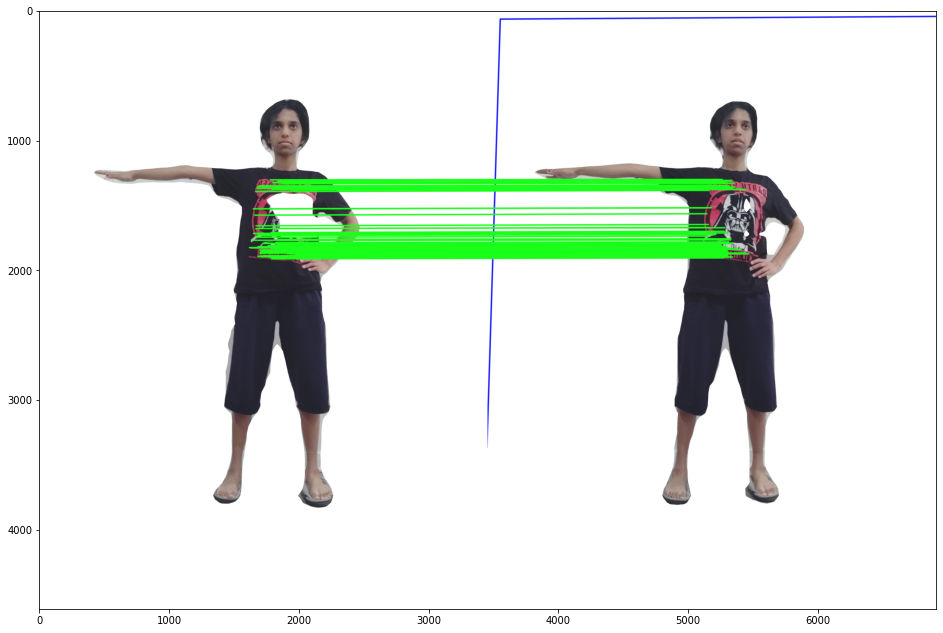

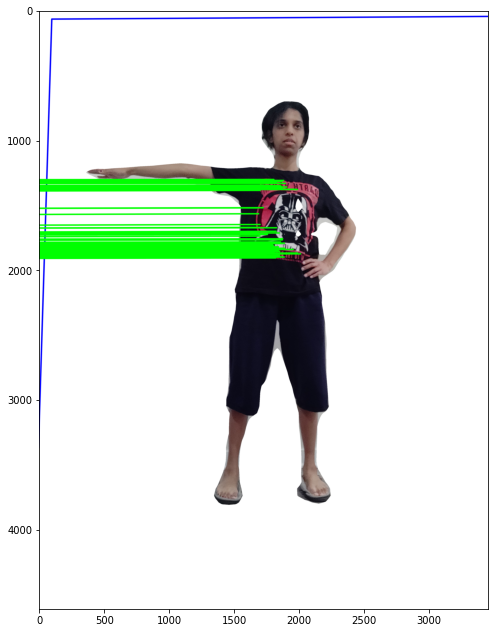

True

In [8]:
"""# 2. A better SIFT implementation????
"""

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_i, des_i = sift.detectAndCompute(im_i, None)
kp_j, des_j = sift.detectAndCompute(im_j, None)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des_i, des_j, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
    
matched_image = cv.drawMatches(im_i[:,:,::-1], kp_i, im_j[:,:,::-1], kp_j, good, None, flags=2)

# plt.figure(figsize=(11*2280/1080, 11))
# plt.title("All Matches")
# d = plt.imshow(matched_image)
# plt.show()


# Find the Homography matrix
image_i = im_i.copy()
image_j = im_j.copy()

MIN_MATCH_COUNT = 10

print('Number of good matches: ', len(good))

if len(good) > MIN_MATCH_COUNT:
    
    src_pts_left  = np.float32([ kp_i[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts_right = np.float32([ kp_j[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    H, mask = cv.findHomography( src_pts_left, dst_pts_right, cv.RANSAC, 5.0 )   # Homography matrix
    H_inv, _ = cv.findHomography( dst_pts_right, src_pts_left, cv.RANSAC, 5.0 )   # Inverse Homography matrix
    print('Homography matrix: ')
    print(H)
    
    matchesMask = mask.ravel().tolist()
    
    h = image_i.shape[0];    w = image_i.shape[1]
    
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    dst = cv.perspectiveTransform(pts, H)
    
    image_j = cv.polylines(image_j, [np.int32(dst)], True, 255, 10, cv.LINE_AA)
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
        
        
draw_params = dict(matchColor = (0, 255, 0),    # draw matches in red color
                   singlePointColor = None,
                   matchesMask = matchesMask,   # draw only inliers
                   matchesThickness = 10,
                   flags = 2)

img3 = cv.drawMatches(image_i, kp_i, image_j, kp_j, good, None, **draw_params)

plt.figure(figsize=(11*2280/1080, 11))
plt.imshow(img3[:,:,::-1], alpha=0.9),plt.show()
plt.show()


img3_right = img3[:, img3.shape[1]//2:][:,:,::-1]

plt.figure(figsize=(11*2280/1080, 11))
plt.imshow(img3_right), plt.show()
cv.imwrite('ref_right.png', img3_right)

## 5. Perform RANSAC and compute and plot and epipolar lines to calculate the true center of the images for the Calibration matrices K and K_prime which will be used for USAC in the next block!

In [9]:
# Compute the alpha parameters of the calibration matrix using approximate intrinsics
# Reference: https://stackoverflow.com/questions/23943602/essential-matrix-from-fundamental-matrix-in-opencv
# f : focal length of the phone camera in mm
# k : pixel scale factor : 1 / (width of 1 pixel in mm)
from lse import least_squares_estimation
from plot_epi import plot_epipolar_lines



"""Set up the variables, assuming approximate image centers == half the height and the width
"""
k = 401 / 25.4      # UNITS: 1/mm      # One Plus 6 has a 401 ppi screen (25.4 mm = 1 inch)
f = 25              # UNITS: mm
alpha_u = k * f
alpha_v = alpha_u   # assuming the same value since all phones have the square pixels!

# ASSUME the image centers for the two images [u0, v0] and [u0_prime, v0_prime] are in the center of the images
u0, v0             = im_i.shape[0]//2, im_i.shape[1]//2    # Assumed Centers, will be corrected in the next block
u0_prime, v0_prime = im_j.shape[0]//2, im_j.shape[1]//2    # Assumed Centers, will be corrected in the next block
# u0 = 307.5          ;         u0_prime = u0
# v0 = 205            ;         v0_prime = v0
# u0 = 0.0            ;         u0_prime = 0.0
# v0 = 0.0            ;         v0_prime = 0.0


"""K and K_prime are the calibration matrices for the two images
"""
K = np.array([[alpha_u,       0,   u0],
              [      0, alpha_v,   v0],
              [      0,       0,    1]])

K_prime = np.array([[alpha_u,       0,   u0_prime],
                    [      0, alpha_v,   v0_prime],
                    [      0,       0,          1]])


"""Now the two sets of uncalibrated points are computed by querying the matches
"""
uncalib_i = np.array([[kp_i[match.queryIdx].pt[0], kp_i[match.queryIdx].pt[1], 1] for match in good])
uncalib_j = np.array([[kp_j[match.trainIdx].pt[0], kp_j[match.trainIdx].pt[1], 1] for match in good])

# calib_i = np.matmul(K, uncalib_i.T).T     # multiplying K with the uncalib pts to "calibrate" them
# calib_j = np.matmul(K_prime, uncalib_j.T).T   # multiplying K with the uncalib pts to "calibrate" them


"""The Fundamental matrix F is computed
"""
F, inlier_status = cv.findFundamentalMat(uncalib_i, uncalib_j, cv.FM_RANSAC, ransacReprojThreshold=4, confidence=0.999, maxIters=10000)
# E = K_prime.T @ F @ K



"""Compute the source and destination points in float32 type for use during rectification
"""
src_pts = np.int32(uncalib_i[:, :2])
src_pts = src_pts[inlier_status.ravel() == 1]

dst_pts = np.int32(uncalib_j[:, :2])
dst_pts = dst_pts[inlier_status.ravel() == 1]

print('Shape of src_pts: ', src_pts.shape)
print('Shape of dst_pts: ', dst_pts.shape)


print('F matrix : ')
print(F)

# Compute and plot epipolar lines
# plot_epipolar_lines(view_i, view_j, uncalib_i.T, uncalib_j.T, E, F, plot=True)

Shape of src_pts:  (162, 2)
Shape of dst_pts:  (162, 2)
F matrix : 
[[ 1.94113979e-07  5.45246443e-06 -1.28496896e-02]
 [-4.84361168e-06 -1.97569822e-07 -2.59961348e-02]
 [ 1.19322814e-02  2.51948531e-02  1.00000000e+00]]


/tmp/ipykernel_60087/341605458.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221), plt.imshow(img5[:,:,::-1])


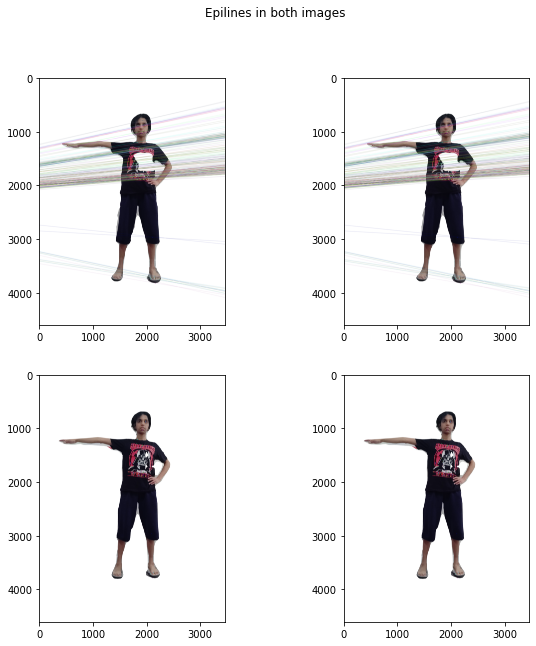

In [10]:
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    
    r, c = im_i.shape[0],im_i.shape[1]
    
    # img1color = cv.cvtColor(im_i, cv.COLOR_GRAY2BGR)
    # img2color = cv.cvtColor(im_j, cv.COLOR_GRAY2BGR)
    
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    
    for r, pt1, pt2 in zip(lines, src_pts, dst_pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(im_i, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(im_i, tuple(pt1), 5, color, -1)
        img2color = cv.circle(im_j, tuple(pt2), 5, color, -1)
    
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
# lines1 = cv.computeCorrespondEpilines(dst_pts.reshape(-1, 1, 2), 2, F)
lines1 = cv.computeCorrespondEpilines(dst_pts, 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(im_i, im_j, lines1, src_pts, dst_pts)


# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(src_pts, 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(im_j, im_i, lines2, dst_pts, src_pts)

plt.subplots(figsize=(10,10))
plt.subplot(221), plt.imshow(img5[:,:,::-1])
plt.subplot(222), plt.imshow(img3[:,:,::-1])
plt.subplot(223), plt.imshow(img6[:,:,::-1])
plt.subplot(224), plt.imshow(img4[:,:,::-1])
plt.suptitle("Epilines in both images")
plt.show()

In [12]:
# plot_epipolar_lines(view_i, view_j, calib_i.T, calib_j.T, E, F, plot=True)

## 9. Calculate the camera pose using USAC/RANSAC for rectification of the 2 views

In [13]:
from ransac import ransac_estimator
# from lse import least_squares_estimator
from usac_magsac import FindFundamentalMatMAGSACplusplus

# F, status = cv.findFundamentalMat(uncalib_i, uncalib_j, cv.FM_RANSAC, ransacReprojThreshold=4, confidence=0.99, maxIters=10000)
F_usac, status = FindFundamentalMatMAGSACplusplus(uncalib_i, uncalib_j, K_prime, K, ransacReprojThreshold=4, confidence=0.99, maxIters=100000)

print('status = ', status, '\n')
print('F matrix with the USAC:')
print(F_usac)

status =  [[1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]


In [14]:
# Difference between E and E_usac:

F_diff = F - F_usac
print(F_diff)

[[ 0.00358317  0.04066202 -0.326716  ]
 [-0.03540033 -0.00465963 -1.14398761]
 [ 0.37404036  1.14293492  1.06599235]]


## 10. Compute the R and T matrices for both views

In [ ]:
"""
from recon3d import reconstruct3D

# count_center = 100                            # The first frame!
# path_center = os.path.normpath("%s/person_%d.png" % (path, count_center))


P1, P2, T, R = reconstruct3D(E, calib_i, calib_j)

print(R)
print('\n\n')
print(T)
"""

## 10. Rectify the two chosen images

In [18]:
# Reference: https://stackoverflow.com/a/62607343
# Compute the two Homography matrices
h1, w1 = im_i.shape[0], im_i.shape[1]
h2, w2 = im_j.shape[0], im_j.shape[1]


"""
# _, H1, H2 = cv.stereoRectifyUncalibrated(src_pts_left, dst_pts_right, F, (w1, h1))
_, H1, H2 = cv.stereoRectifyUncalibrated(src_pts_left, dst_pts_right, F, (w1, h1))

print('H1 matrix: ')
print('\nH2 matrix: ')
"""



# Warping / Rectifying the left and right views
left_rect  = cv.warpPerspective(im_i, np.eye(3), (w1, h1))
right_rect_inv = cv.warpPerspective(im_j, H_inv, (w2, h2))

cv.imwrite("rect_left.png", left_rect)
cv.imwrite("rect_right_inv.png", right_rect_inv)


# Testing
right_rect = cv.warpPerspective(im_j, H, (w2, h2))
cv.imwrite("rect_right.png", right_rect)

# Warping the reference image with H_inv
ref_rect = cv.warpPerspective(img3_right, H, (img3_right.shape[1], img3_right.shape[0]))

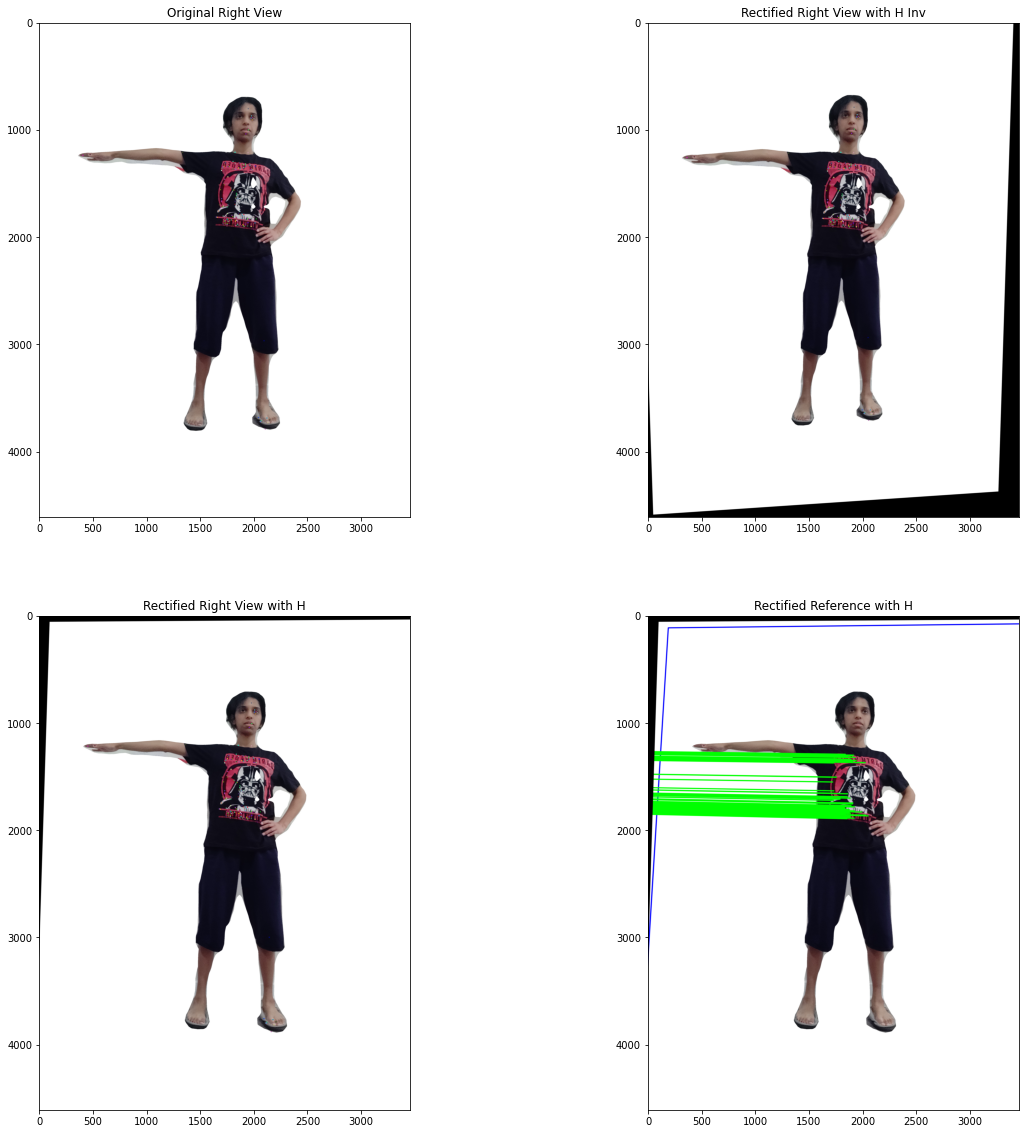

In [19]:
# Plot the rectified views:
f, axs = plt.subplots(2, 2, figsize=(20, 20))

axs[0,0] = plt.subplot(2, 2, 1)
axs[0,0].set_title('Original Right View')
axs[0,0].imshow(im_j[:,:,::-1])

axs[0,1] = plt.subplot(2, 2, 2)
axs[0,1].set_title('Rectified Right View with H Inv')
axs[0,1].imshow(right_rect_inv[:,:,::-1])

axs[1,0] = plt.subplot(2, 2, 3)
axs[1,0].set_title('Rectified Right View with H')
axs[1,0].imshow(right_rect[:,:,::-1])

axs[1,1] = plt.subplot(2, 2, 4)
axs[1,1].set_title('Rectified Reference with H')
axs[1,1].imshow(ref_rect)

## Compute the Depth / Disparity Maps

In [ ]:
imgL = cv.cvtColor(left_rect, cv.COLOR_RGB2GRAY)
imgR = cv.cvtColor(right_rect_inv, cv.COLOR_RGB2GRAY)

img1_L = cv.cvtColor(im_i, cv.COLOR_RGB2GRAY)
img1_R = cv.cvtColor(im_j, cv.COLOR_RGB2GRAY)


B = 457.2                                             # a foot and a half baseline distance


stereo = cv.StereoBM.create(numDisparities=16, blockSize=15)


# depth_map = cv.stereoMatcher.compute(imgL, imgR)

# disparity = 255 - stereo.compute(img1_L, img1_R)
disparity_map = stereo.compute(imgL, imgR)

# make sure the disparity values are all above 0 since we work with uncalibrated data
min_disp = np.min(disparity_map)
if min_disp < 0:
    disparity_map = disparity_map + abs(min_disp) + 1     # the range of values must begin with 0... or 1...?


B = 457.2                                             # a foot and a half baseline distance
depth_map = (K[0][0] * B) / (disparity_map)                # f * B / disp_map


"""
f, axs = plt.subplots(1, 2, figsize=(20, 16))

axs[0] = plt.subplot(1, 2, 1)
axs[0].set_title('Disparity Map')
axs[0].imshow(255 - disparity_map, 'gray')

axs[1] = plt.subplot(1, 2, 2)
axs[1].set_title('Depth Map')
axs[1].imshow(depth_map, 'gray')
"""




"""
from two_view_stereo import compute_disparity_map

disp_map, consistency_mask = compute_disparity_map(
                             left_rect, right_rect, d0=B, k_size=5)
"""


# Plotting the disparity map
print('disp map: ')
plt.figure(figsize=(15,11))
plt.imshow(disp_map, 'Greys')
plt.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
from two_view_stereo import compute_dep_and_pcl

# * 3. compute depth map and filter them
dep_map, xyz_cam = compute_dep_and_pcl(disp_map, B, K_i_corr)

## Compute and Visualize the Point Cloud

In [ ]:
def point_cloud(depth_map, K):
    """Transform a depth image into a point cloud with one point for each
    pixel in the image, using the camera transform for a camera
    centred at cx, cy with field of view fx, fy.

    depth is a 2-D ndarray with shape (rows, cols) containing
    depths from 1 to 254 inclusive. The result is a 3-D array with
    shape (rows, cols, 3). Pixels with invalid depth in the input have
    NaN for the z-coordinate in the result.

    """
    
    u0  = K[0,2];     v0  = K[1,2]      # image center
    f_u = K[0,0];     f_v = K[1,1]      # focal lengths
    
    rows, cols = depth_map.shape[0], depth_map.shape[1]
    
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    
    valid_one = np.sum(depth_map > 0)
    valid_two = np.sum(depth_map < 255)
    
    valid = (depth_map > 0)  # & (depth_map < 255)
    
    print('valid: ', np.sum(valid))
    
    # print('\nvalid shape   : ', valid.shape)
    # print('valid[0,0]      : ', valid[0,0])
    # print('valid[201,350]  : ', valid[201,350])
    # print('valid[1389,2000]: ', valid[1389,2000])
    # print('valid[3500,3400]: ', valid[3500,3400])
    
    z = np.where(valid, depth_map / 256.0, np.nan)
    
    zUnique = np.unique(z)
    print('\nThe unique values in z: ', zUnique)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(z)
    plt.show()
    
    
    x = np.where(valid, z * (c - int(u0)) / f_u, 0)
    y = np.where(valid, z * (r - int(v0)) / f_v, 0)
    
    xUnique = np.unique(x)
    print('\nThe unique values in x: ', xUnique)
    
    yUnique = np.unique(y)
    print('\nThe unique values in y: ', yUnique)
    
    
    plt.figure(figsize=(12, 12))
    plt.imshow(x)
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.imshow(y)
    plt.show()
    
    return np.dstack((x, y, z))

In [ ]:
pcl = point_cloud(depth_map, K)

print('\npcl type: ', type(pcl))
print('size pcl: ', pcl.shape)
print('first value: ', pcl[0,457,:])
print('\n\n')

In [ ]:
def viz_3d_embedded(pcl):    # , color):
    
    plot = k3d.plot(camera_auto_fit=True)
    # color = np.zeros(15925248).astype(np.uint32)
    
    # plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
    
    plot += k3d.points(pcl.astype(float), point_size=0.08, shader="flat")
    plot.display()
    
# viz_3d_embedded(pcl)